There has been a revenue decline in a Portuguese Bank and they would like to know what actions to take. After investigation, they found that the root cause was that their customers are not investing enough for long term deposits. So the bank would like to identify existing customers that have higher chance to subscribe for a long term deposit and focus marketing efforts on such customers.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

##now all the data modelling libraries 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [3]:
data_train = pd.read_csv("binary_test.csv")
data_test = pd.read_csv("binary_train.csv")


In [4]:
data_train.shape

(32950, 16)

In [5]:
data_train.dtypes

age             int64
job            object
marital        object
education      object
default        object
housing        object
loan           object
contact        object
month          object
day_of_week    object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
y              object
dtype: object

In [6]:
data_train.isnull().sum()

age            0
job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
y              0
dtype: int64

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')


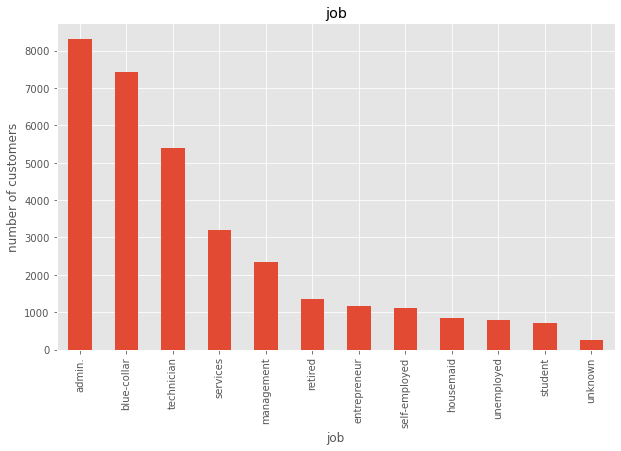

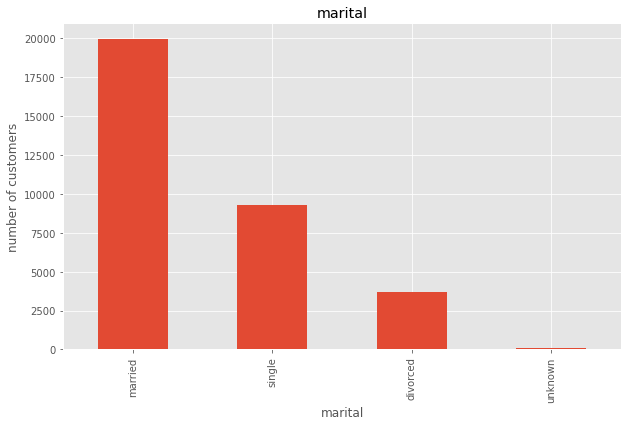

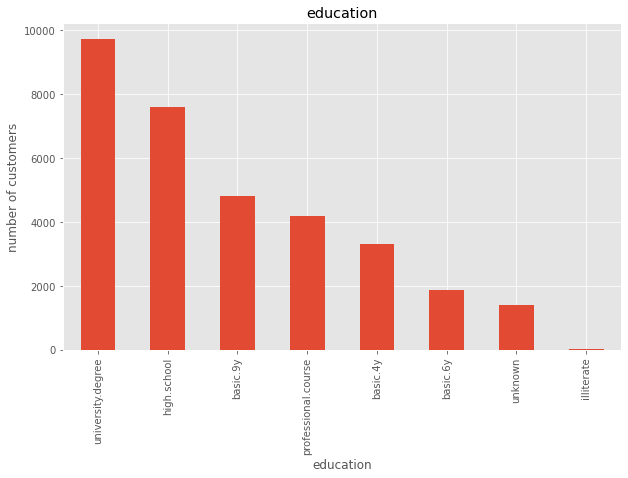

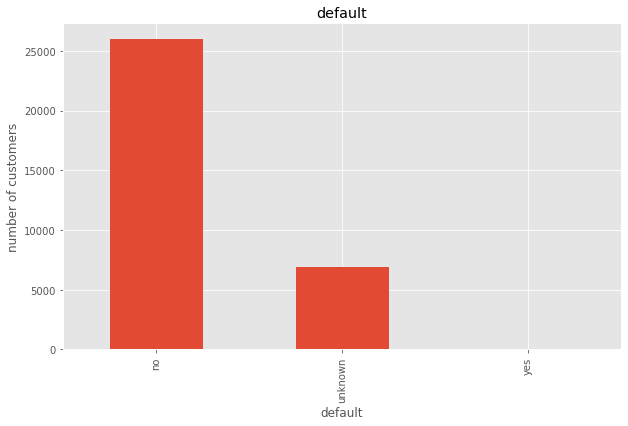

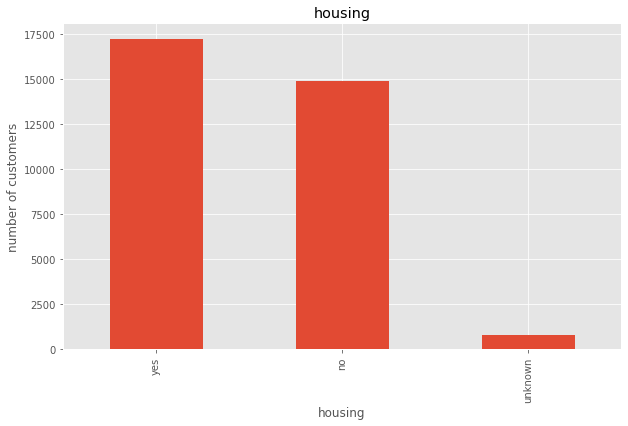

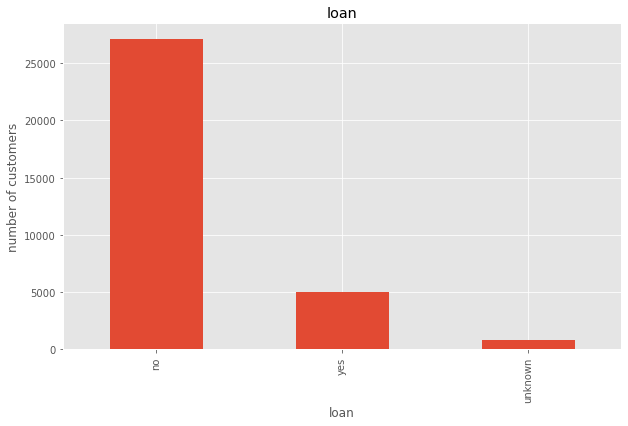

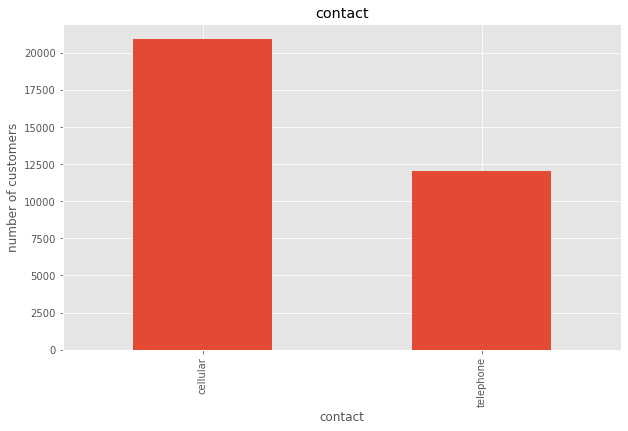

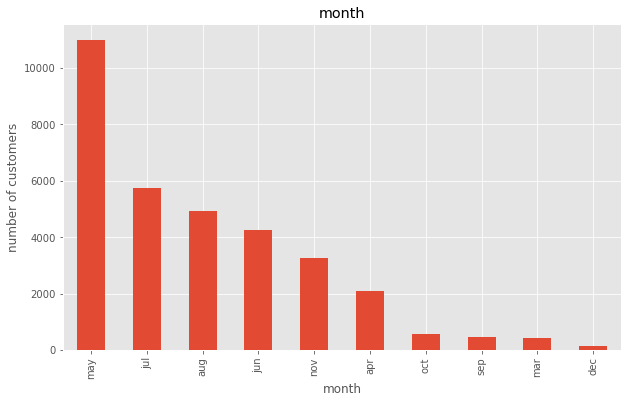

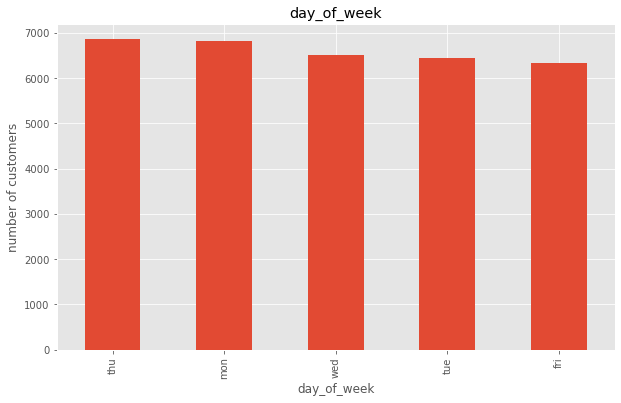

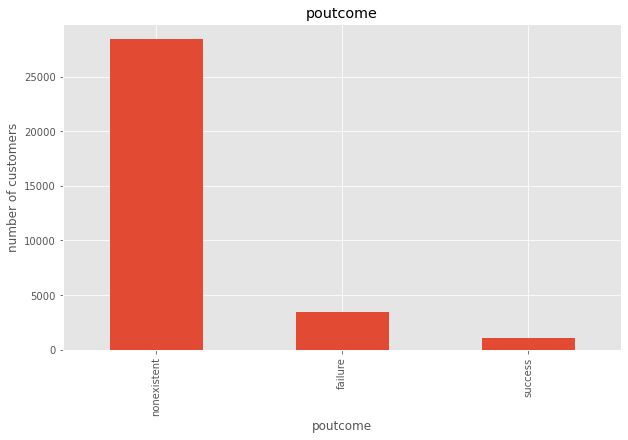

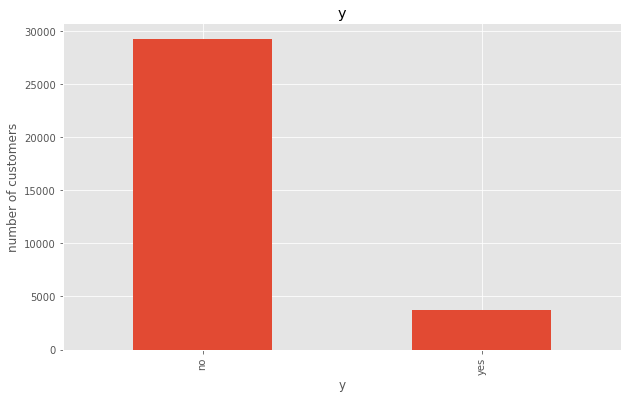

In [7]:
##looking for all the categorical data
cat_var = data_train.select_dtypes(include=["object"]).columns
print(cat_var)

plt.style.use("ggplot")
for column in cat_var:
    plt.figure(figsize=(22,6))
    plt.subplot(121)
    data_train[column].value_counts().plot(kind="bar")
    plt.xlabel(column)
    plt.ylabel("number of customers")
    plt.title(column)

observations that needs to be pointed out:
1. there are few columns where the data is labelled as unknown those are missing data.
2. that most of our customers are married 
3. the top three job profiles of our customers are administrative, blue colar and technician
4. heavy imbalance in the target variable
5. cell-phones are the most used mode of communication 

In [8]:
for column in cat_var:
    mode = data_train[column].mode()[0]
    data_train[column] = data_train[column].replace("unknown", mode)

Univariate Analysis of Numerical variable

In [9]:
num_var = data_train.select_dtypes(include=np.number)
num_var.head(10)

,age,duration,campaign,pdays,previous
0,49,227,4,999,0
1,37,202,2,999,1
2,78,1148,1,999,0
3,36,120,2,999,0
4,59,368,2,999,0
5,29,256,2,999,0
6,26,449,1,999,0
7,30,126,2,999,0
8,50,574,1,999,0
9,33,498,5,999,0


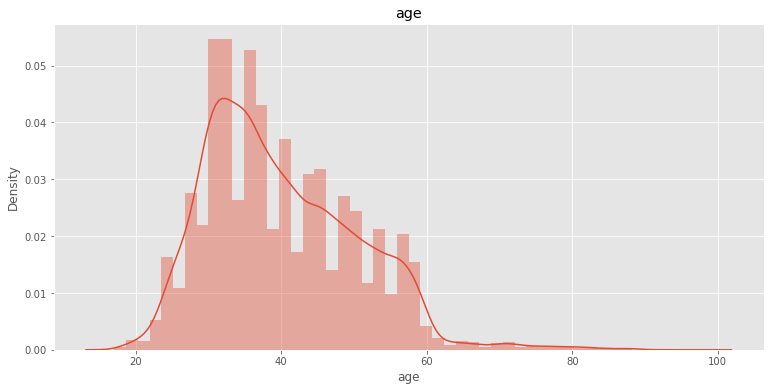

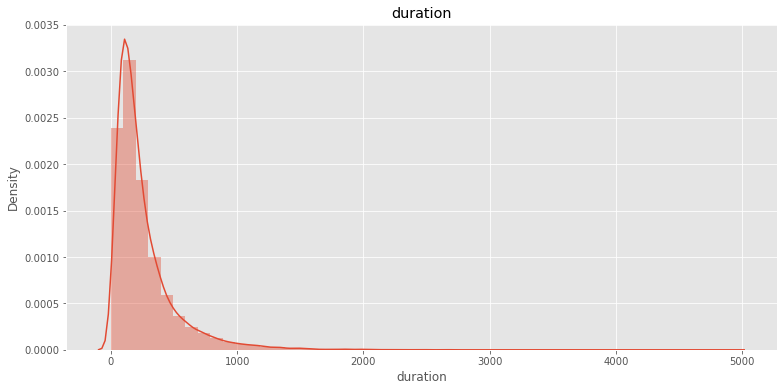

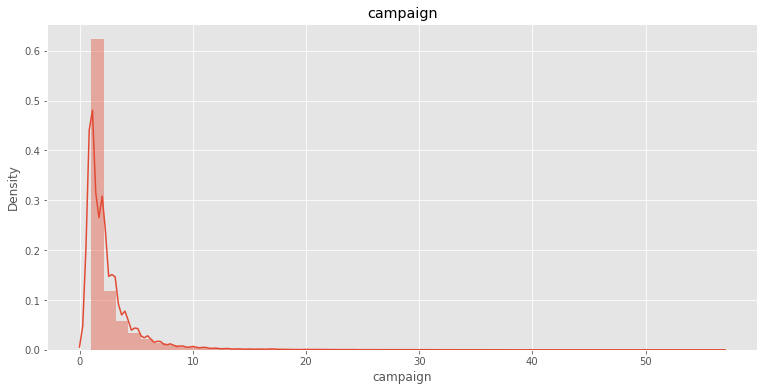

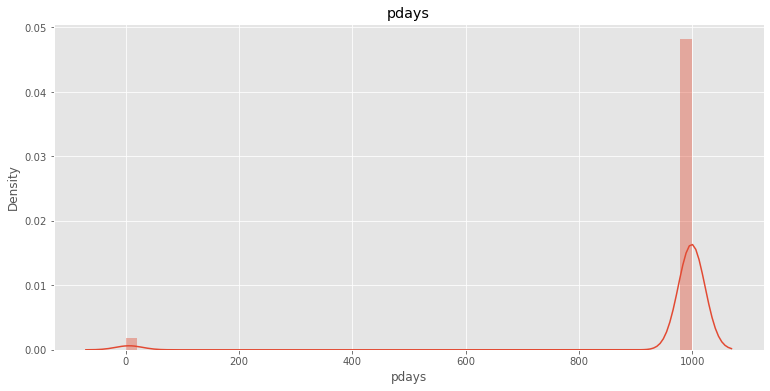

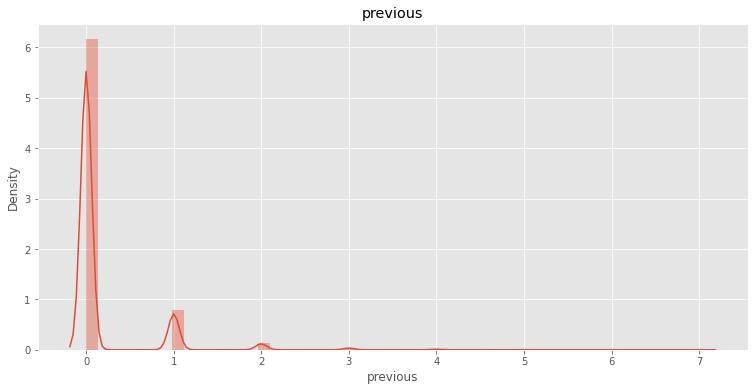

In [10]:
plt.style.use("ggplot")
for column in num_var:
    plt.figure(figsize=(28,6))
    plt.subplot(121)
    sns.distplot(data_train[column], kde=True)
    plt.title(column)

The age, duration and campaigns are highly skewed 
looking at the previous and pdays columns it is visible that they only have one single value majorly there will be no problem dropping them

In [12]:
data_train.drop(columns=["pdays", "previous"], axis = 1, inplace=True)

Bivariate Analysis of Categorical Columns

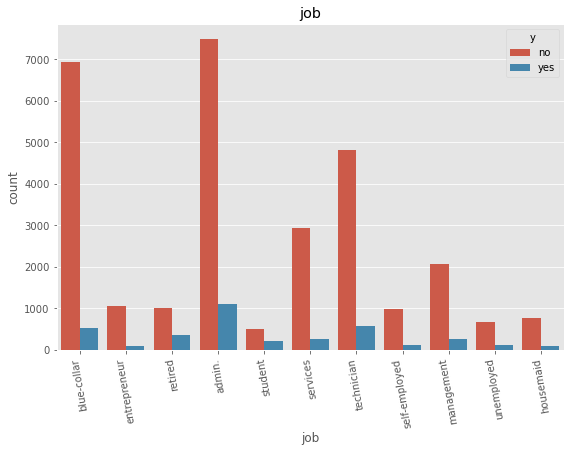

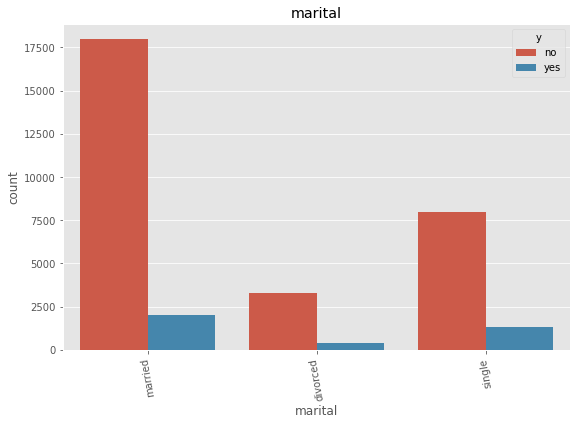

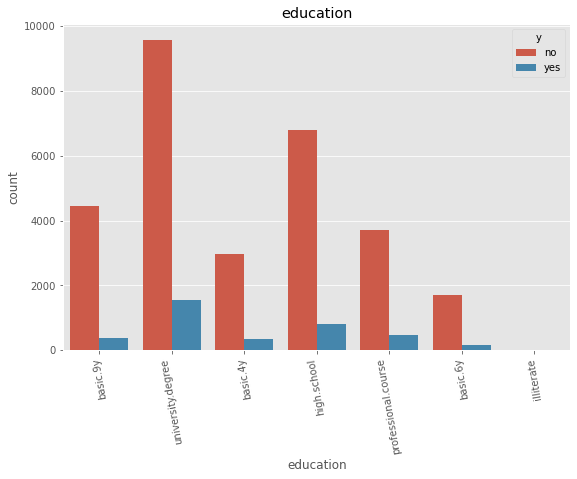

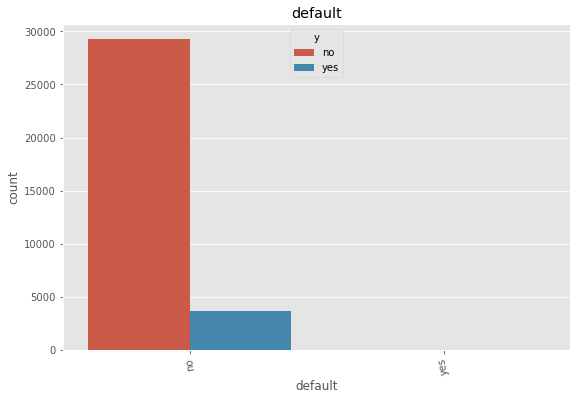

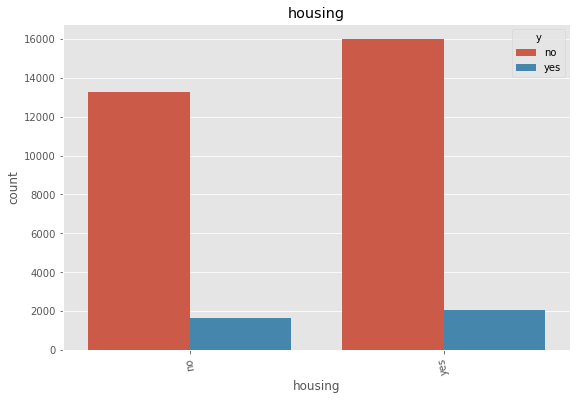

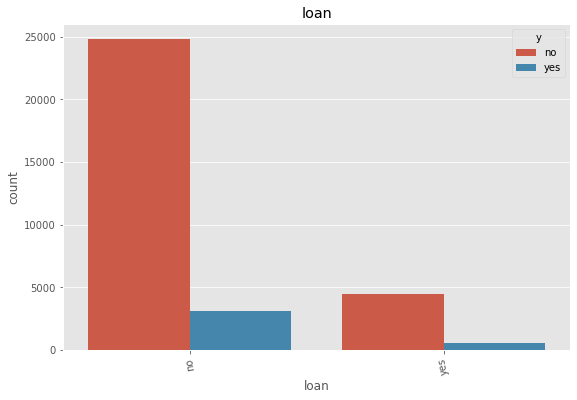

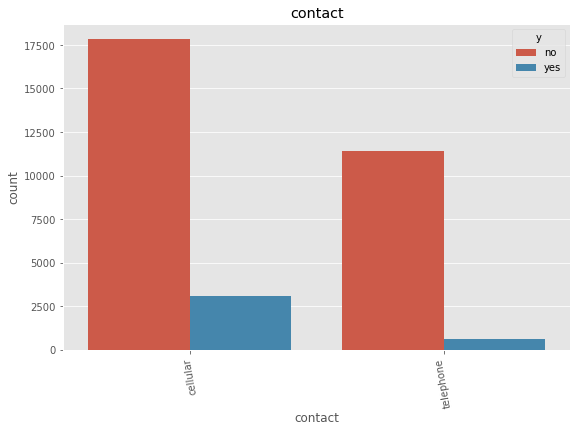

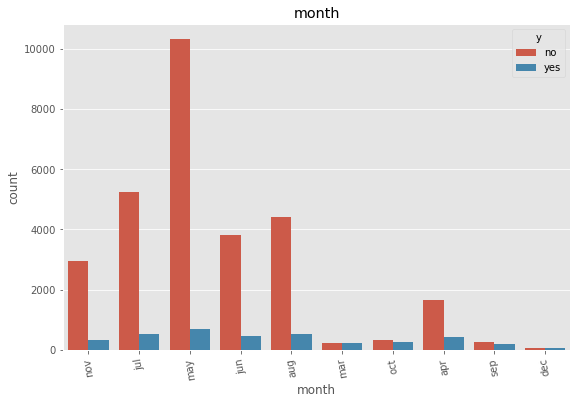

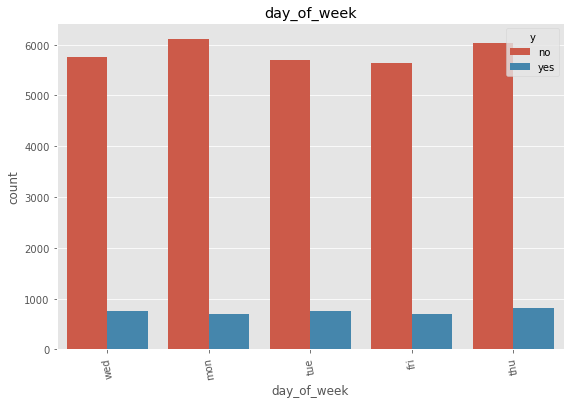

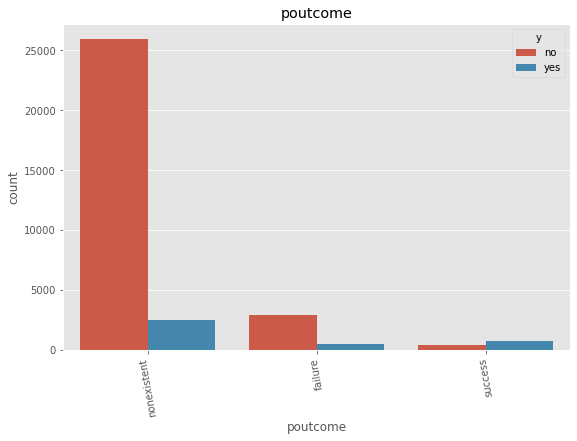

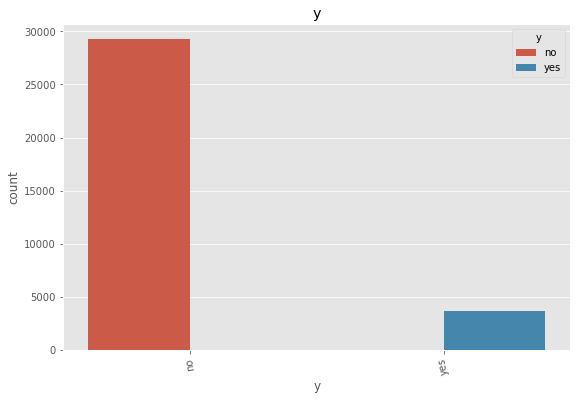

In [14]:
plt.style.use("ggplot")
for column in cat_var:
    plt.figure(figsize=(20,6))
    plt.subplot(121)
    sns.countplot(data_train[column], hue=data_train["y"])
    plt.title(column)
    plt.xticks(rotation=100)

In [15]:
##Handling outliers
data_train.describe()

,age,duration,campaign
count,32950.000000,32950.000000,32950.000000
mean,40.014112,258.127466,2.560607
std,10.403636,258.975917,2.752326
min,17.000000,0.000000,1.000000
25%,32.000000,103.000000,1.000000
50%,38.000000,180.000000,2.000000
75%,47.000000,319.000000,3.000000
max,98.000000,4918.000000,56.000000


the age, duration and campaign are skewed towards the right thus we will compute the IQR and replace the outliers 

In [19]:
lower_boundaries = []
upper_boundaries = []
for i in ["age", "duration", "campaign"]:
    IQR = data_train[i].quantile(0.75) - data_train[i]. quantile(0.25)
    lower_bound = data_train[i].quantile(0.25) - (1.5*IQR)
    upper_bound = data_train[i].quantile(0.75) + (1.5*IQR)
    print(i, ":", lower_bound, ",", upper_bound)
    lower_boundaries.append(lower_bound)
    upper_boundaries.append(upper_bound)

age : 9.5 , 69.5
duration : -221.0 , 643.0
campaign : -2.0 , 6.0


In [23]:
j = 0 
for i in ["age", "duration", "campaign"]:
    data_train.loc[data_train[i] > upper_boundaries[j], i] = int(upper_boundaries[j])
    j = j + 1

In [24]:
data_train.describe()

,age,duration,campaign
count,32950.000000,32950.000000,32950.000000
mean,39.929894,234.923915,2.271077
std,10.118566,176.854558,1.546302
min,17.000000,0.000000,1.000000
25%,32.000000,103.000000,1.000000
50%,38.000000,180.000000,2.000000
75%,47.000000,319.000000,3.000000
max,69.000000,643.000000,6.000000


In [25]:
##Encoding categorical variables
for i in cat_var:
    print(i, ":", data_train[i].unique())

job : ['blue-collar' 'entrepreneur' 'retired' 'admin.' 'student' 'services'
 'technician' 'self-employed' 'management' 'unemployed' 'housemaid']
marital : ['married' 'divorced' 'single']
education : ['basic.9y' 'university.degree' 'basic.4y' 'high.school'
 'professional.course' 'basic.6y' 'illiterate']
default : ['no' 'yes']
housing : ['no' 'yes']
loan : ['no' 'yes']
contact : ['cellular' 'telephone']
month : ['nov' 'jul' 'may' 'jun' 'aug' 'mar' 'oct' 'apr' 'sep' 'dec']
day_of_week : ['wed' 'mon' 'tue' 'fri' 'thu']
poutcome : ['nonexistent' 'failure' 'success']
y : ['no' 'yes']


In [26]:
##Label encoding the values as one hot encoding is not advisible as there would be too many columns
LE = LabelEncoder()
for feature in cat_var:
    data_train[feature] = LE.fit_transform(data_train[feature])

In [27]:
data_train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome,y
0,49,1,1,2,0,0,0,0,7,4,227,4,1,0
1,37,2,1,6,0,0,0,1,7,4,202,2,0,0
2,69,5,1,0,0,0,0,0,3,1,643,1,1,1
3,36,0,1,6,0,1,0,1,6,1,120,2,1,0
4,59,5,0,6,0,0,0,0,4,3,368,2,1,0


In [28]:
x = data_train.iloc[:,:-1]
y = data_train.iloc[:,-1]

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3,  random_state=42)

In [31]:
##Grid Search and HYperparameter tuning
log_reg = LogisticRegression()

log_param = {"C": 10.0**np.arange(-2,3), "penalty":["l1", "l2"]}

cv_log = StratifiedKFold(n_splits=5)

gridsearch_log = GridSearchCV(log_reg, log_param, cv=cv_log, scoring = "f1_macro", n_jobs=-1, verbose=2)

gridsearch_log.fit(x_train, y_train)

print("best score is:" , gridsearch_log.best_score_)
print("best parameters are:" , gridsearch_log.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
best score is: 0.6211560029776247
best parameters are: {'C': 1.0, 'penalty': 'l2'}


[[8507  216]
 [ 943  219]]
0.8827516439049065
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      8723
           1       0.50      0.19      0.27      1162

    accuracy                           0.88      9885
   macro avg       0.70      0.58      0.61      9885
weighted avg       0.85      0.88      0.86      9885



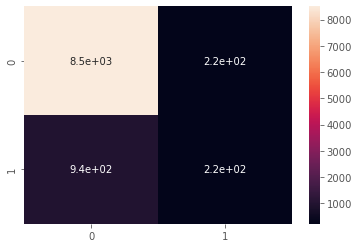

In [32]:
##CHecking model performance
y_predicted = gridsearch_log.predict(x_test)

cm = confusion_matrix(y_test, y_predicted)
print(cm)
sns.heatmap(cm, annot=True)
print(accuracy_score(y_test, y_predicted))
print(classification_report(y_test, y_predicted))